In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import data
import sklearn.metrics
import tensorflow as tf


# 1. Generating data which is not linearly separable

In our experiments in lab 0, logistic regression achieved quite good classification results. This should not be viewed as a surprise since the sigmoid of affine transformed data was a good fit for the chosen posterior probability of data classes. Our experiments slightly digressed from ideal theoretical assumptions (our classes had different covariances) but results showed that this digression did not hurt the performance of our algorithm. Now we will make the things a little harder by instantiating the data with a more complex generative model.

Instructions:

- Write a subroutine `sample_gmm_2d(K, C, N)` which creates `K` random bivariate Gaussian distributions, and samples `N` data points from each of them. Unlike in `sample_gauss_2d`, here we need to assign class `c_i` to each bivariate distribution `G_i`, where c_i is randomly sampled from the set `{0, 1, ..., C-1}`. This way we get the data generated by mixtures of randomly chosen Gaussian distributions. The function should return a data matrix `X` and the groundtruth class matrix `Y`. The rows of both matrices correspond to sampled data points. The matrix `X` contains the data, while Y contains the class index of the generating distribution.
- The implementation of the subroutine first should create random distributions and assign them a random class from 0 to `C - 1`. Then, it must sample the required number of data points from each of the distributions and assign these data the corresponding class index.
- The subroutine should return the following data:

```
X  ... data in a matrix [K·N x 2 ]
Y_ ... class indices of data [K·N]
```

Run the subroutine `sample_gmm_2d` and test it by invoking drawing functions developed in lab exercise 0 (`graph_surface` and `graph_data`). Depending on the parameters and the state of the random number generator, your result could look similar to the figure below. Our parameters were: `K=4`, `C=2`, `N=30`.

-- image

When you are satisfied with the execution results, save the code in the file `data.py`. 

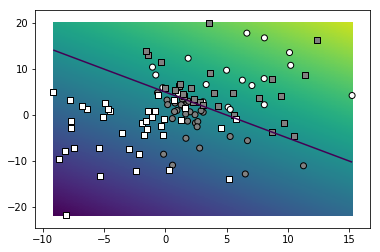

In [3]:
def sample_gmm_2d(K, C, N):
    '''
    K - number of distributions
    C - number of classes
    N - number of data points assigned to specific class
    '''
    distributions = []
    classes = []
    for i in range(K):
        distributions.append(data.Random2DGaussian())
        classes.append(np.random.randint(C))
    
    X = np.vstack([d.get_sample(N) for d in distributions])
    Y_ = np.hstack([[c]*N for c in classes])
    return X,Y_


np.random.seed(100)

X,Y_ = sample_gmm_2d(K=4, C=2, N=30)
Y = data.myDummyDecision(X)>0

bbox=(np.min(X, axis=0), np.max(X, axis=0))
data.graph_surface(data.myDummyDecision, bbox, offset=0)
data.graph_data(X, Y_, Y)
plt.show()



# 2. Multi layer classification in Python

In this exercise you shall develop an algorithm for learning a probabilistic classification model with one hidden layer, by employing the negative log-likelihood loss and stochastic gradient descent. Your algorithm should be stored in the module `fcann2`. The organization of the module should follow the example set by the module logreg from the lab exercise 0. The module should contain the methods `fcann2_train` and `fcann2_classify`. The module should be tested on an artificial dataset containing 2D data of two classes sampled from a Gaussian mixtures of 6 components.

Depending on parameters and the seed of the random number generator, your result could look like in the figure below. Our hyper-parameters were: `K=6`, `C=2`, `N=10`, `param_niter=1e5`, `param_delta=0.05`, `param_lambda=1e-3` (regularization coefficient), hidden layer dimensionality: `5`.

-- image

When you are satisfied with the execution results, save the code in the file `fcann2.py`. 

iteration 0: loss 59.65851605673248
iteration 1000: loss 23.492846529783883
iteration 2000: loss 23.53929435976088
iteration 3000: loss 23.470327784396062
iteration 4000: loss 23.471351251686453
iteration 5000: loss 23.34222399824884
iteration 6000: loss 23.31323299321264
iteration 7000: loss 23.306340152258027
iteration 8000: loss 23.42258018015345
iteration 9000: loss 23.567044047719232
accuracy: 0.8166666666666667


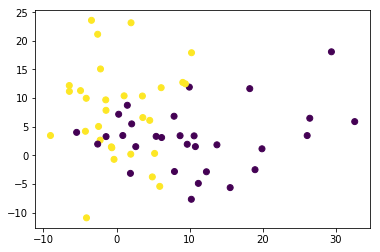

In [4]:
def fcann2_train(X,Y_, param_niter=10000, param_delta=0.05, param_lambda=1e-3, hidden_layer_dim=5):
    '''
    Arguments
        X:  data, np.array NxD
        Y_: class indices, np.array Nx1
    Return values
        w1, b1, w2, b2: parameters
    '''
    num_of_features = X.shape[1]
    num_of_elements = X.shape[0]
    param_delta /= num_of_elements
    C = max(Y_)+1 # number of classes
    # model with 2 layers - one hidden and one exit layer, so w1, b1, w2, b2
    # size of w1,b1 vec. - "5" - hidden_layer_dim - stohastic gradient descent
    w1 = np.array([np.random.randn(num_of_features) for i in range(hidden_layer_dim)])
    b1 = np.array([0.0 for i in range(hidden_layer_dim)])
    w2 = np.array([np.random.randn(hidden_layer_dim) for i in range(C)])
    b2 = np.array([0.0 for i in range(C)]) # Cx1
    
    # stochastic gradient descent (param_niter iteratons)
    for i in range(int(param_niter)):
        # classification scores size = NxC
        #    classes:
        #    c1 c2 c3 ...
        # n1
        # n2
        # n3 ...
        
        #hidden layer
        scores1 = np.dot(X, w1.transpose()) + b1 # NxC
        #ReLU
        h1 = np.maximum(0, scores1) #NxC
        # exit/output layer and softmax calculation
        scores2 = np.dot(h1, w2.transpose())+b2 # NxC
        expscores2 = np.exp(scores2) # NxC
        sumexp2 = expscores2.sum(axis=1) # Nx1
        
        # negative log-likelihood loss
        probs2 = (expscores2.transpose() / sumexp2).transpose() # NxC
        correct_class_prob = probs2[range(len(X)), Y_]
        correct_class_logprobs = -np.log(correct_class_prob) # Nx1
        loss  = correct_class_logprobs.sum()
        
        # trace
        if i % int(param_niter/10) == 0:
            print("iteration {}: loss {}".format(i, loss))

        # derivative of the loss funciton with respect to classification scores

        dscores2 = probs2 # NxC
        # @lab0:
        # Using Iversonovim brackets to denote the influence of the corresponding
        # input category, we can then define the partial derivative of the loss function
        # with respect to the classification score
        dscores2[range(num_of_elements),Y_] -= 1
        
        dw2 = np.dot(dscores2.transpose(), h1) # CxH
        db2 = dscores2.sum(axis=0) # Cx1

        dh1 = np.dot(dscores2, w2)  # NxH

        dscores1 = dh1  # NxH
        dscores1[scores1 <= 0] = 0

        dw1 = np.dot(dscores1.transpose(), X) # HxD
        db1 = dscores1.sum(axis=0)  # Hx1

        # update
        w1 += -param_delta * dw1
        b1 += -param_delta * db1
        w2 += -param_delta * dw2
        b2 += -param_delta * db2

    return (w1, b1, w2, b2)

def fcann2_classify(X, w1, b1, w2, b2):
    '''
    Parameters
    ----------
    X : 2-D array_like, of shape (N, 2)
        data
    w : 2-D array_like, of shape (C, 2)
        array of weights for each feature
    b: 1-D array like of length C
        bias parameter

    Returns
    -------
    probs : 2-D array_like, of shape (N, C)
        probability of classes for each sample in X
    '''
    scores1 = np.dot(X, w1.transpose()) + b1 # NxH
    #ReLU
    h1 = np.maximum(0, scores1) # NxH
    scores2 = np.dot(h1, w2.transpose()) + b2 # NxC

    #softmax
    expscores = np.exp(scores2) # NxC
    sumexp = expscores.sum(axis=1) # Nx1

    return (expscores.transpose() / sumexp).transpose() 


np.random.seed(32)
X, Y = sample_gmm_2d(6, 2, 10)
##X=np.array([[1,3],[1,1],[3,2], [3,3]]);Y=np.array([1,0,2,2])
w1, b1, w2, b2 = fcann2_train(X,Y)

Y_ = np.empty((0,0), dtype=np.int64)
# get class by doing argmax on vector (highest value = predicted class)
##for v in fcann2_classify(X, w1, b1, w2, b2):
##    Y_ = np.append((Y_), np.argmax(v))
Y_= np.argmax(fcann2_classify(X, w1, b1, w2, b2), axis=1) # axis=1 - horizontally

accuracy, conf_mat, prec_recall = data.eval_perf_multi(Y,Y_)
print('accuracy:', accuracy)

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

# 3. Linear regression in Tensorflow

We illustrate a typical structure of a machine learning algorithm in Tensorflow on a complete example of the optimization procedure for estimating the parameters of a line `y = a * x + b` passing through points `(1,3)` and `(2,5)`. 

0 [(-4.25, 0.0), (-2.0, 0.0)] 0.0 0.0 [[-8.5]] -4.0
10 [(-0.3989808, 1.8295592), (-0.19497016, 0.8657209)] 1.8295592 0.8657209 [[-0.7979616]] -0.38994032
20 [(-0.035331815, 1.9999155), (-0.023519322, 0.95308816)] 1.9999155 0.95308816 [[-0.07066363]] -0.047038645
30 [(-0.0012882054, 2.013789), (-0.0066041574, 0.9661084)] 2.013789 0.9661084 [[-0.00257641]] -0.013208315
40 [(0.0016450584, 2.0131807), (-0.004395306, 0.97143817)] 2.0131807 0.97143817 [[0.00329012]] -0.008790612
50 [(0.0016762912, 2.0114706), (-0.0036618412, 0.97547054)] 2.0114706 0.97547054 [[0.00335258]] -0.0073236823
60 [(0.0014675856, 2.009886), (-0.003140837, 0.9788892)] 2.009886 0.9788892 [[0.00293517]] -0.006281674
70 [(0.0012651682, 2.0085113), (-0.002702877, 0.9818274)] 2.0085113 0.9818274 [[0.00253034]] -0.005405754
80 [(0.0010896921, 2.007327), (-0.0023265034, 0.9843563)] 2.007327 0.9843563 [[0.00217938]] -0.004653007
90 [(0.0009381771, 2.0063076), (-0.0020027235, 0.9865331)] 2.0063076 0.9865331 [[0.00187635]] -0.

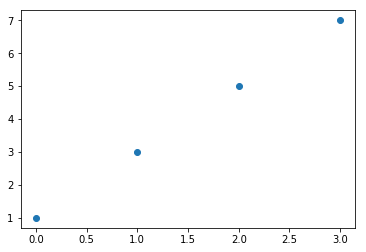

In [5]:

### samples vectors
x = [0,1];y = [1,3]
#x = [0,1,2];y = [1,3,5]
x = [0,1,2,3];y = [1,3,5,7]
x=np.array(x).reshape(-1,1);y=np.array(y).reshape(-1,1)
num_samples = len(x)
###


## 1. definition of the computation graph
# data and parameters
X  = tf.placeholder(tf.float32, [None,1])
Y_ = tf.placeholder(tf.float32, [None,1])
a = tf.Variable(0.0)
b = tf.Variable(0.0)

# affine regression model
Y = a * X + b

# Modify the program so that a line is fit to an arbitrary number of points.
# Ensure that the magnitude of the gradients does not depend on the count of the data. 
loss = ((Y-Y_)**2)/(num_samples**2)

# optimization by gradient descent
#trainer = tf.train.GradientDescentOptimizer(0.1)
#train_op = trainer.minimize(loss)

## Express the optimization step by calling methods compute_gradients and apply_gradients. 
opt = tf.train.GradientDescentOptimizer(0.1)
grads_and_vars = opt.compute_gradients(loss, [a, b]) # Compute the gradients for a list of variables.
op = opt.apply_gradients(grads_and_vars) # Ask the optimizer to apply the capped gradients.

## 2. parameter initialization
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Define analytical expression for the loss gradient w.r.t. parameters a and b.Define the nodes which
## calculate the gradients explicitly, and evaluate them by invoking the method run. Print out values of
## the gradients and make sure they are equal to the values determined by Tensorflow. 
dL_dscores = Y-Y_
grad_a = (1/num_samples) * tf.matmul(dL_dscores, X, transpose_a=True)
grad_b = (1/num_samples) * tf.reduce_sum(dL_dscores) # np.sum() == tf.reduce_sum()
'''
## from lab0:
# gradients with respect to parameters
N_elements, N_classes = X.shape
grad_w = 1/N_elements * np.dot(dL_dscores.transpose(), X)
grad_b = 1/N_elements * np.sum(dL_dscores)
'''

## 3. training
# let the games start!
for i in range(100):
    ## Fetch and print the gradient values during optimization by evaluating (run)
    ## the gradients returned by compute_gradients.
    val_loss = sess.run(loss, feed_dict={X: x, Y_: y})
    val_grads = sess.run(grads_and_vars, feed_dict={X: x, Y_: y})
    val_grad_a, val_grad_b = sess.run([grad_a, grad_b], feed_dict={X: x, Y_: y})
    val_a, val_b = sess.run([a, b], feed_dict={X: x, Y_: y})
    sess.run(op, feed_dict={X: x, Y_: y})
    if i%10==0: print(i, val_grads, val_a, val_b, val_grad_a, val_grad_b)
    if i==99: print(i, val_grads, val_a, val_b, val_grad_a, val_grad_b)
plt.plot(x, val_a*x + val_b, 'o')
plt.show()

Assignments:

- Analyze the provided program and check the execution correctness.
- Modify the program so that a line is fit to an arbitrary number of points. Ensure that the magnitude of the gradients does not depend on the count of the data.
- [Express](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#processing_gradients_before_applying_them) the optimization step by calling methods `compute_gradients` and `apply_gradients`.
- Fetch and print the gradient values during optimization by evaluating (`run`) the gradients returned by `compute_gradients`. Take into account that `compute_gradients` returns a list of tuples (gradient, variable), while the method `run` receives a list of nodes in a single positional argument.
- Define analytical expression for the loss gradient w.r.t. parameters `a` and `b`. Define the nodes which calculate the gradients explicitly, and evaluate them by invoking the method `run`. Print out values of the gradients and make sure they are equal to the values determined by Tensorflow.
- Show that values of the gradients may be printed using the function [tf.Print](https://www.tensorflow.org/api_docs/python/tf/Print). 

When you are satisfied with the execution results, save the code in the file `fcann2.py`. 

# 4. Logistic regression in Tensorflow

In this assignment we shall express the logistic regression under Tensorflow. The source code will be only half as long as the corresponding "hand made" code from the lab 0. The exercise will demonstrate the following Tensorflow advantages: i) we don't need to derive gradients, and ii) the code may be executed on different processing platforms (CPU, GPU) without making substantial changes. These advantages will be crucial in cases of large models with hundres of millions of parameters (in smaller models, a CPU implementation may be faster due to expensive transfers from RAM to GPU).

In the introductory examples we have seen that Tensorflow programs often need to use two names for the same tensor. The first name references the node in the computation graph, whereas the second name references a value of that node for specific input data (eg. `loss` and `val_loss`, or a and val_a). To avoid the need for duplicated naming, the algorithm can be expressed as a class whose data members reference the graph nodes. This allows the client code to use the same names to refer to the specific tensor values. Following these guidelines, a class for logistic regression under Tensorflow could have the structure as follows. 

In [6]:
class TFLogreg:
    def __init__(self, D, C, param_delta=0.5, param_lambda=1e-3):
        """Arguments:
           - D: dimensions of each datapoint 
           - C: number of classes
           - param_delta: training step
        """

        # declare graph nodes for the data and parameters:
        # self.X, self.Yoh_, self.W, self.b
        self.X = tf.placeholder(tf.float64, [None, D])
        self.Yoh_ = tf.placeholder(tf.float64, [None,C])
        self.W = tf.Variable(np.array([np.random.randn(D) for i in range(C)])) # weights == columns == number of features # CxD
        self.b = tf.Variable(np.array([0.0 for i in range(C)]))
        
        # formulate the model: calculate self.probs
        #   use tf.matmul, tf.nn.softmax
        scores = tf.matmul(self.X, self.W, transpose_b=True) + self.b
        self.probs = tf.nn.softmax(scores)
        
        # formulate the loss: self.loss
        #   use tf.log, tf.reduce_sum, tf.reduce_mean
        # L(W,b|D)=∑_i−logP(Y=y_i|x_i)
        minuslog = -tf.log(self.probs)
        sumlog = tf.reduce_sum(self.Yoh_ * minuslog, axis=1)
        self.loss = tf.reduce_mean(sumlog)

        # formulate the training operation: self.train_step
        #   use tf.train.GradientDescentOptimizer,
        #       tf.train.GradientDescentOptimizer.minimize
        opt = tf.train.GradientDescentOptimizer(0.1) # defining step
        self.train_step = opt.minimize(self.loss) # minimizing loss

        # instantiate the execution context: self.session
        #   use tf.Session
        self.session = tf.Session()


    def train(self, X, Yoh_, param_niter):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # parameter intiailization
        #   use tf.global_variables_initializer !! deprecated
        self.session.run(tf.global_variables_initializer())

        data_in = {self.X: X, self.Yoh_: Yoh_}
        # optimization loop
        #   use tf.Session.run
        ## tf.Session = self.session, so self.session.run()
        for i in range(param_niter):
            loss_val = self.session.run(self.loss, feed_dict=data_in)
            self.session.run(self.train_step, feed_dict=data_in)
            if i%100==0:
                print('{} loss: {}'.format(i, loss_val))
        print('{} loss: {}'.format(i, loss_val))


    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        #   use tf.Session.run
        ## tf.Session = self.session, so self.session.run()
        return self.session.run(self.probs, feed_dict={self.X: X})


Notice that unlike the previous exercise the true labels of the training data are now called `Yoh_` instead of `Y_`. This is due to the fact that, in Tensorflow, the cross entropy loss is more easily expressed by organizing the labels in a matrix n which the rows correspond to data points while the columns correspond to class labels (this is also known as one-hot notation). If a data point $x_i$ matches the class `c_j`, then `Yoh_[i,j]=1` and `Yoh_[i,k]=0` for all `k!=j` ("one hot"). In former mathematical discussion, data labels organized in such manner were referenced by the matrix $Y′$

The structure of a test program should be very similar to the test programs from the previous exercise: 

0 loss: 1.528859718912373
100 loss: 0.35476122778234104
200 loss: 0.19133202280434716
300 loss: 0.13027550997950368
400 loss: 0.09836655342825618
500 loss: 0.07877889027426686
600 loss: 0.06556497720621404
700 loss: 0.0560712924003906
800 loss: 0.04893361480834651
900 loss: 0.04337938195664111
999 loss: 0.03897889651779116


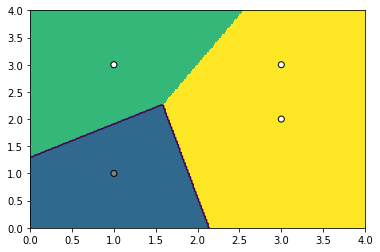

In [7]:
if __name__ == "__main__":
    # initialize the random number generator
    np.random.seed(100)
    tf.set_random_seed(100)
    tf.reset_default_graph() 

    # instantiate the data X and the labels Yoh_
    X = np.array([[1,3],[1,1],[3,2],[3,3]])
    Y_ = np.array([1,0,2,2])
    '''
    Yoh c1 c2 c3
     x1 0  1  0
     x2 1  0  0
     x3 0  0  1
     x4 0  0  1
    '''
    Yoh_ = np.zeros((len(X), len(np.bincount(Y_))))
    Yoh_[range(len(Y_)), Y_] = 1
    ## Yoh_s = tf.one_hot(D,C)
    
    '''
    N_classes = 3
    N_examples = 2 # examples from each class, so 3*10=30 in total
    X, Y_ = data.sample_gauss_2d(N_classes, N_examples)
    Yoh_ = np.zeros((N_examples*N_classes, N_classes))
    Yoh_[range(len(Y_)), Y_] = 1
    Yoh_ = tf.one_hot(Y_, N_classes)
    '''

    # build the graph:
    tflr = TFLogreg(X.shape[1], Yoh_.shape[1], 0.5)

    # perform the training with given hyper-parameters:
    tflr.train(X, Yoh_, 1000)

    # predict probabilities of the data points
    probs = tflr.eval(X)

    # print performance (per-class precision and recall)

    # draw results, decision surface
    decfun = lambda x: tflr.eval(x).argmax(axis=1)
    bbox=(np.min(X-1, axis=0), np.max(X+1, axis=0))
    data.graph_surface(decfun, bbox, offset=0.5)
    '''
    ## assign one color to each class
    import matplotlib
    c = matplotlib.cm.rainbow(np.linspace(0, 1, len(np.bincount(Y_))))
    for i, p in enumerate(X):
        plt.scatter(p[0], p[1], color=c[Y_[i]])
    '''
    #Y = [np.argmax(p) for p in probs]
    Y = np.argmax(probs, axis=1)
    
    data.graph_data(X, Y_, Y)
    plt.show()

Assignments:

- Complete the implementation of the class `TFLogreg` and check whether your program achieves the same results as the corresponding programs from lab 0.
- Add regularization in a way that you form the loss as a sum of cross entropy and the L2 norm of the vectorized weight matrix multiplied with a hyperparameter `param_lambda`. Test the effect of regularization to the shape of the decision surface.
- Experiment with different values of hyperparameters. Find combinations of hyperparameters for which your program is unable to find a satisfcatory solution and try to explain what is happening. 

A: lambda around 0.3 and above - model starts to be unreliable
lambda above 0.8 - model is unreliable

When you are satisfied with the execution results, save the code in the file `tf_logreg.py`. 

# 5. Configurable deep models in Tensorflow

Our next task is to expand the Tensorflow implementation of logistic regression in a way to enable simple creation of configurable fully connected classification models. Your solution should be encapsulated in the class `TFDeep` which should have the same interface as the class `TFLogreg`. The `TFDeep` constructor receives the configuration hyperparameter in the form of a list of layer dimensionalities. The element at index 0 defines the dimensionality of the data. Elements at indices `1` to `n-2` (if any) define the number of activations in hidden layers. The last number in the configuration list (the element at index `n-1`) corresponds to the number of classes (the model is supposed to perform the classification).

For example, a configuration `[2,3]` gives rise to multi-class logistic regression of two dimensional data into three classes. The configuration `[2,5,2]` specifies a model with one hidden layer `h` which contains `5` activations:

```python
h = f (X * W_1 + b_1)
probs = softmax(h * W_2 + b_2) 
```

In this example, the dimensions of graph nodes should be as follows (question marks stand for the unknown cardinality of the data set we apply the model to):

```
  X     ... [?,2]
  W_1   ... [2,5]
  b_1   ... [1,5]
  h_1   ... [?,5]
  W_2   ... [5,3]
  b_2   ... [1,3]
  probs ... [?,3]
```

Implementation of the class `TFDeep` should be very similar to what we had for the `TFLogreg` class. Most of the work will be in the constructor because now the graph construction depends on the configuration hyperparameter. Since the number of hidden layers may differ, the weight matrices and bias vectors should be placed in lists (let's call them `self.W` and `self.b`). The same goes for matrices of hidden layers which can be stored in the list `self.h`. Parameter dimensions can be defined within a loop through the configuration list. For better readability of the source code, we advise to factor the formulation of the model into a separate function. Hidden layer nonlinearities can be defined using TensorFlow's functions `tf.ReLU`, `tf.sigmoid` or `tf.tanh`.


In [8]:
class TFDeep:
    def __init__(self, configuration, activation_f, param_delta=0.5, param_lambda=1e-3):
        """Arguments:
           - D: dimensions of each datapoint 
           - C: number of classes
           - param_delta: training step
        """
        D = configuration[0]
        C = configuration[-1]

        np.random.seed(100)
        tf.set_random_seed(100)
        tf.reset_default_graph() 
        
        if len(configuration) < 2:
            raise ValueError('configuration has to have at least input and output layer')
        if D != configuration[0]:
            raise ValueError('Input layer length do not match with configuration')
        if C != configuration[-1]:
            raise ValueError('Output layer length do not match with configuration')

        ### data input
        # declare graph nodes for the data and parameters:
        # self.X, self.Yoh_, self.W, self.b
        self.X = tf.placeholder(tf.float64, [None, D])
        self.Yoh_ = tf.placeholder(tf.float64, [None,C])
        
        ## 
        self.W_array = []
        previous_layer = self.X
        regularization_loss = 0
        for i in range(len(configuration)-1):
            '''
            eg config = [2, 5, 3]
            i=0 _prev = 2  _next = 5
            i=1 _prev = 5  _next = 3
            '''
            _prev = configuration[i]
            _next = configuration[i+1]
            W = tf.Variable(np.array([np.random.randn(_prev) for i in range(_next)])) # weights == columns == number of features # CxD
            b = tf.Variable(np.array([0.0 for i in range(_next)]))
            self.W_array = W
            
            regularization_loss += tf.nn.l2_loss(W)
        
            # formulate the model: calculate self.probs
            #   use tf.matmul, tf.nn.softmax
            scores = tf.matmul(previous_layer, W, transpose_b=True) + b
            
            ## last layer -> use softmax - output layer
            if i == (len(configuration)-2):
                previous_layer = tf.nn.softmax(scores)
            else:    
                ## other layers -> use specified activation function
                previous_layer = activation_f(scores)
        
        self.probs = previous_layer
        # formulate the loss: self.loss
        #   use tf.log, tf.reduce_sum, tf.reduce_mean
        # L(W,b|D)=∑_i−logP(Y=y_i|x_i)
        '''
        minuslog = -tf.log(self.probs)
        sumlog = tf.reduce_sum(self.Yoh_ * minuslog, axis=1)
        self.loss = tf.reduce_mean(sumlog)
        '''
        probs_sum = tf.reduce_sum(self.Yoh_ * -tf.log(self.probs), axis=1)
        self.loss = tf.reduce_sum(tf.reduce_mean(probs_sum) + param_lambda*regularization_loss)

        # formulate the training operation: self.train_step
        #   use tf.train.GradientDescentOptimizer,
        #       tf.train.GradientDescentOptimizer.minimize
        opt = tf.train.GradientDescentOptimizer(param_delta) # defining step
        self.train_step = opt.minimize(self.loss) # minimizing loss

        # instantiate the execution context: self.session
        #   use tf.Session
        self.session = tf.Session()
        
        # parameter intiailization
        self.session.run(tf.global_variables_initializer())

    def get_weights(self):
        return self.session.run(self.W_array)

    def train(self, X, Yoh_, param_niter, verbose=True):
        """Arguments:
           - X: actual datapoints [NxD]
           - Yoh_: one-hot encoded labels [NxC]
           - param_niter: number of iterations
        """
        # parameter intiailization
        ## initializer moved to __init__ -> allow additional training of weights

        data_in = {self.X: X, self.Yoh_: Yoh_}
        # optimization loop
        #   use tf.Session.run
        ## tf.Session = self.session, so self.session.run()
        for i in range(param_niter):
            loss_val = self.session.run(self.loss, feed_dict=data_in)
            self.session.run(self.train_step, feed_dict=data_in)
            if verbose and i%(1 if int(param_niter/10)==0 else int(param_niter/10))==0:
                print('{} loss: {}'.format(i, loss_val))
                
        if verbose: print('{} loss: {}'.format(i, loss_val))


    def eval(self, X):
        """Arguments:
           - X: actual datapoints [NxD]
           Returns: predicted class probabilites [NxC]
        """
        #   use tf.Session.run
        ## tf.Session = self.session, so self.session.run()
        return self.session.run(self.probs, feed_dict={self.X: X})



Assignments:

- Implement the class `TFDeep` and try out configuration `[2,3]` on the same data as in the former assignment (the test code should be very similar). Make sure the results are the same as before.
- Make sure that all model parameters are given suitable symbolic names (if necessary, help yourself with the [documentation](https://www.tensorflow.org/api_docs/python/tf/Variable)). Write a method `count_params` which prints out symbolic names of all trainable parameters by traversing the return value of the function `tf.trainable_variables`. Print the total number of model parameters (e.g. for configuration `[2,3]` the result should be `9`).


(4, 2)
0 loss: 1.5317595869562703
100 loss: 0.08702223305512206
200 loss: 0.05095853860403176
300 loss: 0.03969300621123602
400 loss: 0.03440365789184027
500 loss: 0.0313800907283974
600 loss: 0.02943159638337447
700 loss: 0.028069680828129454
800 loss: 0.027060848802481444
900 loss: 0.026280957509960727
999 loss: 0.025664103495868833


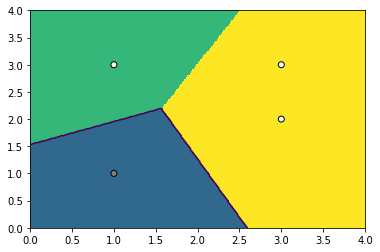

In [9]:
if __name__ == "__main__":
    # initialize the random number generator
    np.random.seed(100)
    tf.set_random_seed(100)
    tf.reset_default_graph() 

    # instantiate the data X and the labels Yoh_
    X = np.array([[1,3],[1,1],[3,2],[3,3]])
    print(X.shape)
    Y_ = np.array([1,0,2,2])
    '''
    Yoh c1 c2 c3
     x1 0  1  0
     x2 1  0  0
     x3 0  0  1
     x4 0  0  1
    '''
    Yoh_ = np.zeros((len(X), len(np.bincount(Y_))))
    Yoh_[range(len(Y_)), Y_] = 1
    ## Yoh_s = tf.one_hot(D,C)
    
    activation_f = tf.nn.relu
    #activation_f = tf.sigmoid
    #activation_f = tf.tanh
    
    configuration = [2, 3]
    
    # build the graph:
    tfdeep = TFDeep(configuration, activation_f, 0.5)

    # perform the training with given hyper-parameters:
    tfdeep.train(X, Yoh_, 1000)

    # predict probabilities of the data points
    probs = tfdeep.eval(X)

    # print performance (per-class precision and recall)

    # draw results, decision surface
    decfun = lambda x: tfdeep.eval(x).argmax(axis=1)
    bbox=(np.min(X-1, axis=0), np.max(X+1, axis=0))
    data.graph_surface(decfun, bbox, offset=0.5)
    Y = np.argmax(probs, axis=1)
    data.graph_data(X, Y_, Y)
    plt.show()
    

- Try out your code on data returned by calling `data.sample_gmm_2d(4, 2, 40)` and `data.sample_gmm_2d(6, 2, 10)`, using configurations `[2,2]`, `[2,10,2]` and `[2,10,10,2]`. Print accuracy, recall, precision and average precision. Display the classification results and observe the decision surface. If there is no convergence, consider changing the hyperparameters.



neural=[2, 2]
distrib=[4, 2, 40]
0 loss: 8.131434288890807
50 loss: 0.640721891559344
100 loss: 0.6387310269072017
150 loss: 0.6384363158866709
200 loss: 0.6383915552713918
250 loss: 0.6383846839127301
300 loss: 0.6383836245284371
350 loss: 0.6383834609207112
400 loss: 0.6383834356364139
450 loss: 0.6383834317275658
499 loss: 0.6383834311270989
accuracy=0.61875
prec_recall=[[0.61728395 0.625     ]
 [0.62025316 0.6125    ]]

neural=[2, 10, 2]
distrib=[4, 2, 40]
0 loss: 12.225227052325648
50 loss: 0.6607633386166708
100 loss: 0.5759423940050882
150 loss: 0.5574850410928329
200 loss: 0.5262437539049655
250 loss: 0.5114216947735952
300 loss: 0.5059196917303019
350 loss: 0.4963718039176266
400 loss: 0.4915294943956904
450 loss: 0.4859888004851906
499 loss: 0.4850975987506289
accuracy=0.7375
prec_recall=[[0.7375 0.7375]
 [0.7375 0.7375]]

neural=[2, 10, 10, 2]
distrib=[4, 2, 40]
0 loss: 3.2278752530731563
50 loss: 0.5265890190518281
100 loss: 0.4895648857916271
150 loss: 0.47172803817288955

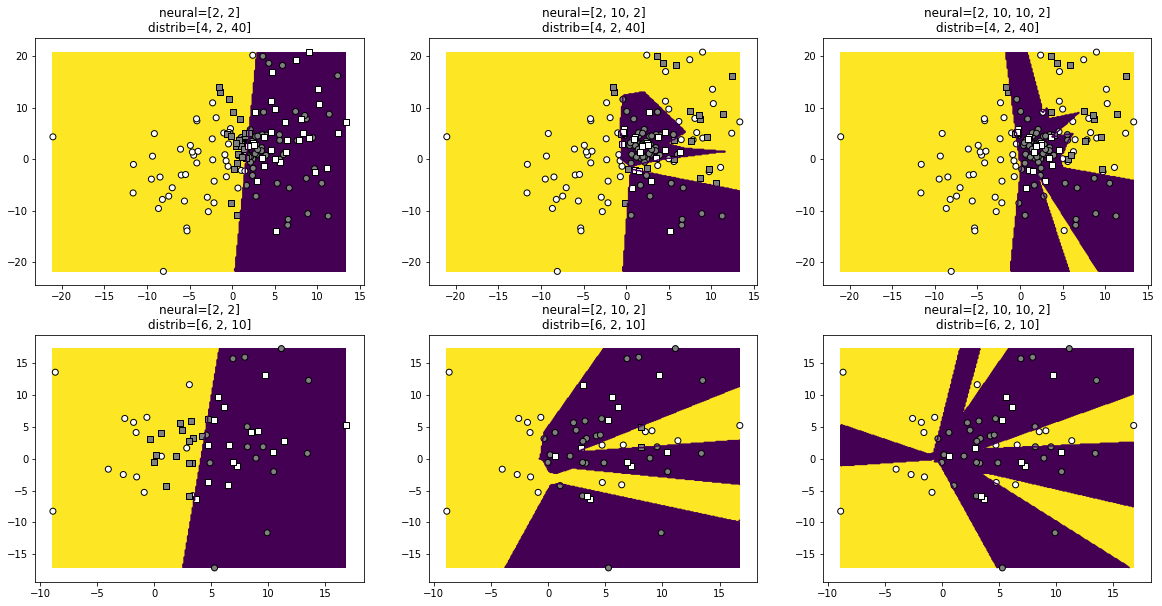

In [10]:
if __name__ == "__main__":
    
    plt.rcParams['figure.figsize'] = [20, 10]
    
    neural_configurations = [[2,2], [2,10,2], [2,10,10,2]]
    distribution_params = [[4,2,40], [6,2,10]]
    i=0
    for dp in distribution_params:
        for nc in neural_configurations:
            # initialize the random number generator
            np.random.seed(100)
            tf.set_random_seed(100)
            tf.reset_default_graph()
            i+=1
            print()
            print('neural={}\ndistrib={}'.format(nc,dp))
            # instantiate the data X and the labels Yoh_
            X, Y_ = sample_gmm_2d(*dp)
            Yoh_ = np.zeros((len(X), len(np.bincount(Y_))))
            Yoh_[range(len(Y_)), Y_] = 1
    
            activation_f = tf.nn.relu
            #activation_f = tf.sigmoid
            #activation_f = tf.tanh
    
            # build the graph:
            tfdeep = TFDeep(nc, activation_f, 0.05, 1e-6)

            # perform the training with given hyper-parameters:
            tfdeep.train(X, Yoh_, 500)

            # predict probabilities of the data points
            probs = tfdeep.eval(X)

            # print performance (per-class precision and recall)

            # draw results, decision surface
            plt.subplot(2, 3, i)
            decfun = lambda x: tfdeep.eval(x).argmax(axis=1)
            bbox=(np.min(X, axis=0), np.max(X, axis=0))
            data.graph_surface(decfun, bbox, offset=0.5)
            Y = np.argmax(probs, axis=1)
            plt.title('neural={}\ndistrib={}'.format(nc,dp))
            data.graph_data(X, Y_, Y)
            accuracy, conf_mat, prec_recall = data.eval_perf_multi(Y,Y_)
            print('accuracy={}\nprec_recall={}'.format(accuracy, prec_recall))
    plt.show()
    

- Compare the results obtained with the hidden activation function set to `ReLU` and the sigmoid function. For small problems, sigmoid may achieve better results than `ReLU` due to continuity. The main advantage of the `ReLU` is that it doesn't saturate, so there are no vanishing gradients in deeper models. 

0 loss: 8.131434288890807
50 loss: 0.640721891559344
100 loss: 0.6387310269072017
150 loss: 0.6384363158866709
200 loss: 0.6383915552713918
250 loss: 0.6383846839127301
300 loss: 0.6383836245284371
350 loss: 0.6383834609207112
400 loss: 0.6383834356364139
450 loss: 0.6383834317275658
499 loss: 0.6383834311270989
0 loss: 12.225227052325648
50 loss: 0.6607633386166708
100 loss: 0.5759423940050882
150 loss: 0.5574850410928329
200 loss: 0.5262437539049655
250 loss: 0.5114216947735952
300 loss: 0.5059196917303019
350 loss: 0.4963718039176266
400 loss: 0.4915294943956904
450 loss: 0.4859888004851906
499 loss: 0.4850975987506289
0 loss: 3.2278752530731563
50 loss: 0.5265890190518281
100 loss: 0.4895648857916271
150 loss: 0.47172803817288955
200 loss: 0.4661234062834464
250 loss: 0.4598321481623227
300 loss: 0.45158654426146716
350 loss: 0.443908849436404
400 loss: 0.4446092001606812
450 loss: 0.4418282383906545
499 loss: 0.43554784398790636
0 loss: 8.131434288890807
50 loss: 0.640721891559344

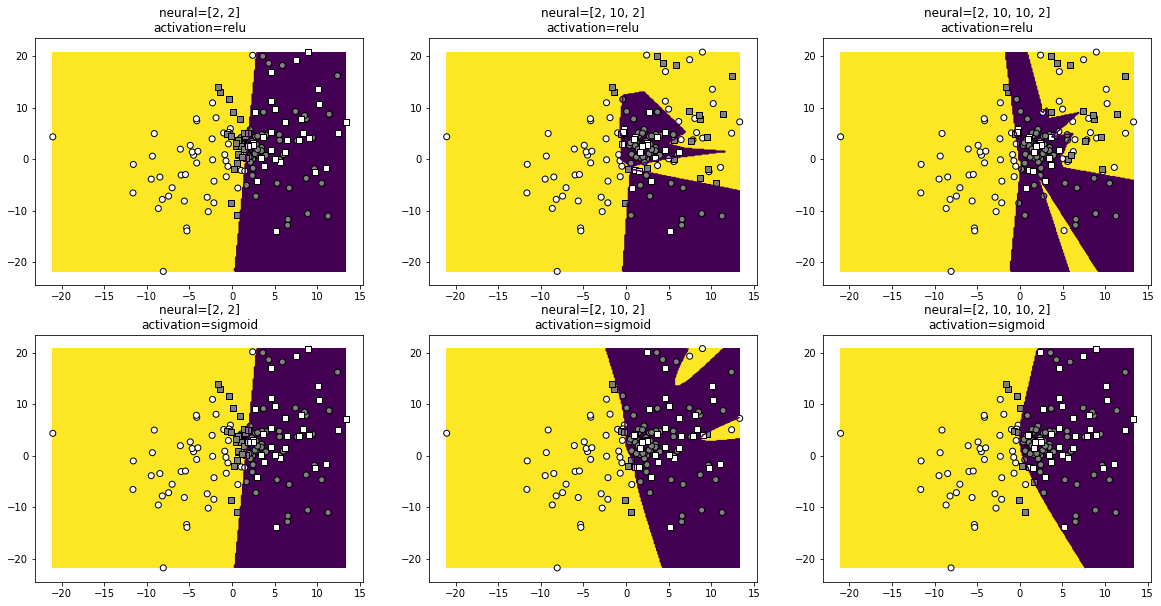

In [11]:
if __name__ == "__main__":
    
    plt.rcParams['figure.figsize'] = [20, 10]
    
    neural_configurations = [[2,2], [2,10,2], [2,10,10,2]]
    activation_functions = [tf.nn.relu, tf.sigmoid]
    i=0
    for af in activation_functions:
        for nc in neural_configurations:
            # initialize the random number generator
            np.random.seed(100)
            tf.set_random_seed(100)
            tf.reset_default_graph()
            i+=1
            # instantiate the data X and the labels Yoh_
            X, Y_ = sample_gmm_2d(4,2,40)
            Yoh_ = np.zeros((len(X), len(np.bincount(Y_))))
            Yoh_[range(len(Y_)), Y_] = 1
    
            activation_f = af
            #activation_f = tf.nn.relu
            #activation_f = tf.sigmoid
            #activation_f = tf.tanh
    
            # build the graph:
            tfdeep = TFDeep(nc, activation_f, 0.05, 1e-6)

            # perform the training with given hyper-parameters:
            tfdeep.train(X, Yoh_, 500)

            # predict probabilities of the data points
            probs = tfdeep.eval(X)

            # print performance (per-class precision and recall)

            # draw results, decision surface
            plt.subplot(2, 3, i)
            decfun = lambda x: tfdeep.eval(x).argmax(axis=1)
            bbox=(np.min(X, axis=0), np.max(X, axis=0))
            data.graph_surface(decfun, bbox, offset=0.5)
            Y = np.argmax(probs, axis=1)
            plt.title('neural={}\nactivation={}'.format(nc,af.__name__))
            data.graph_data(X, Y_, Y)
    plt.show()
    


Based on parameters and the state of the random number generator, your result could be similar to the animation below (our hyperparameters were: `K=6`, `C=2`, `N=10`, `param_niter=1e4`, `param_delta=0.1`, `param_lambda=1e-4` (regularization coefficient), `config=[2,10,10,2]`, `ReLU`).

-- image

When you are satisfied with the execution results, save the code in the `file tf_logreg.py`. 

# 6. Comparison to a kernel SVM

Recall the properties of the kernel SVM (model, loss, optimization) and read the documentation od the module `svm` from the library `scikit-learn`. Design the class KSVMWrap as a thin wrapper around the module `sklearn.svm` which you are going to be apply to the same two-dimensional data as before. Considering the spmlicity of our wrapper, the training can be done from the constructor, while class predictions, classification scores (required for average precision) and support vectors can be fetched in methods. Make the interface of the class as follows:

```python
Metode:
  __init__(self, X, Y_, param_svm_c=1, param_svm_gamma='auto'):
    Constructs the wrapper and trains the RBF SVM classifier
    X,Y_:            data and indices of correct data classes
    param_svm_c:     relative contribution of the data cost
    param_svm_gamma:  RBF kernel width

  predict(self, X):
    Predicts and returns the class indices of data X

  get_scores(self, X):
    Returns the classification scores of the data
    (you will need this to calculate average precision).

  suport:
    Indices of data chosen as support vectors
```


In [45]:
from sklearn import svm

class SVMWrap():
    def __init__(self, X, Y_, param_svm_c=1, param_svm_gamma='auto'):
        '''
        Constructs the wrapper and trains the RBF SVM classifier
        X,Y_:            data and indices of correct data classes
        param_svm_c:     relative contribution of the data cost
        param_svm_gamma:  RBF kernel width
        '''
        self.model = svm.SVC(kernel='rbf', C=param_svm_c, gamma=param_svm_gamma)
        self.model.fit(X, Y_)
    

    def predict(self, X):
        '''
        Predicts and returns the class indices of data X
        '''
        return self.model.predict(X)
    

    def get_scores(self, X):
        '''
        Returns the classification scores of the data
        (you will need this to calculate average precision).
        '''
        pass

    def suport(self):
        '''
        Indices of data chosen as support vectors
        '''
        pass
    
    def get_perf(self, Y, Y_):
        # accuracy, conf_mat, prec_recall = data.eval_perf_multi(Y,Y_)
        return data.eval_perf_multi(Y,Y_)
    


Assignments:

- Modify the function `data.graph.data` by introducing the argument `special`. The argument `special` assigns a list of data indices which are to be emphasized by doubling the size of their symbols.
- Test your class on the data from two classes sampled from mixtures of Gaussian distributions. As usual, display the standard performance metrics (accuracy, recall, precision, average precision).
- Compare the model performance implemented by classes `TFDeep` and `KSVMWrap` on a larger number of random data sets. What are the pros and cons of their loss functions? Which of the two guarantees a better performance? Which of the two can take a larger number of parameters? Which of the two would be more suitable for 2D data sampled from Gaussian mixtures?
- Plot the decision surface and classification results of RBF SVM. Make us of the argument `special` of the function `data.graph.data` to emphasize the display of support vectors. Based on the parameters and the random number generator, your results could resemble the following animation. (our hyperparameters were: `K=6`, `C=2`, `N=10`, `param_svm_c=1`, `param_svm_gamma='auto'`). 

-- image

When you are satisfied with the execution results, save the code in the file `tf_logreg.py`. 


svm perf:
(0.6, array([[2., 6.],
       [0., 7.]]), array([[1.        , 0.25      ],
       [0.53846154, 1.        ]]))
0 loss: 8.948262032966047
150 loss: 1.538926226712023
300 loss: 1.5058649791250576
450 loss: 1.5624050666338387
600 loss: 1.5010719196833053
750 loss: 1.5632932328576545
900 loss: 1.5010379957260673
1050 loss: 1.56329789814804
1200 loss: 1.5010378240519453
1350 loss: 1.5632979216850396
1499 loss: 5.443486367047984


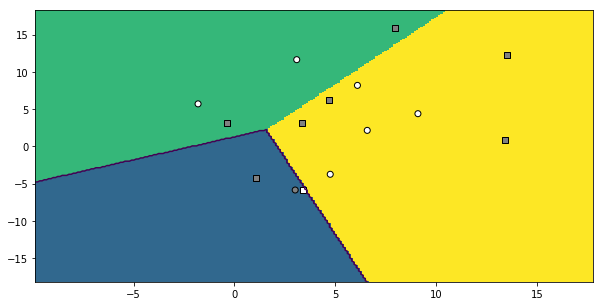

[1 1 1 1 1 1 1 0 1 1 1 0 1 1 1]
[1 1 1 0 0 0 0 1 0 1 1 0 1 0 0]

tfdeep perf:
(0.4666666666666667, array([[1., 7.],
       [1., 6.]]), array([[0.5       , 0.125     ],
       [0.46153846, 0.85714286]]))


In [101]:
np.random.seed(100)
tf.set_random_seed(100)
tf.reset_default_graph()

K=6
C=2
N=10

X, Y_ = sample_gmm_2d(K, C, N)
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y_)
Yoh_ = np.zeros((len(X), len(np.bincount(Y_))))
Yoh_[range(len(Y_)), Y_] = 1
Yoh_train = np.zeros((len(X_train), len(np.bincount(Y_train))))
Yoh_train[range(len(Y_train)), Y_train] = 1
Yoh_test = np.zeros((len(X_test), len(np.bincount(Y_test))))
Yoh_test[range(len(Y_test)), Y_test] = 1

param_svm_c=1
param_svm_gamma='auto'
_svm = SVMWrap(X_train, Y_train, param_svm_c=param_svm_c, param_svm_gamma=param_svm_gamma)
print('\nsvm perf:\n{}'.format(_svm.get_perf(_svm.predict(X_test), Y_test)))


conf = [2,C]
activation = tf.nn.relu
#configuration, activation_f, param_delta=0.5, param_lambda=1e-3):
tfdeep = TFDeep(conf, activation, 0.5, 1e-6)
tfdeep.train(X_train, Yoh_train, 1500)
probs = tfdeep.eval(X_test)

# draw results, decision surface
decfun = lambda x: tflr.eval(x).argmax(axis=1)
bbox=(np.min(X-1, axis=0), np.max(X+1, axis=0))
data.graph_surface(decfun, bbox, offset=0.5)
Y = np.argmax(probs, axis=1)
data.graph_data(X_test, Y_test, Y)
plt.show()
print('\ntfdeep perf:\n{}'.format(data.eval_perf_multi(Y, Y_test)))



# 7. Case study: MNIST

So far, the trained models haven't been evaluated on a separate test set. Such experiments can not provide an estimate of the generalization performance. They are therefore appropriate only in early experiments where we test whether a model has enough capacity for the given task.

In this exercise we shall explore generalization performance on real data. The MNIST dataset is a collection of hand-written images of digits from 0 to 9. Each digit is represented by an image of 28x28 pixels. MNIST contains 50000 training images and 10000 testing images. The dataset can be (down)loaded with the following code:

```python
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.app.flags.DEFINE_string('data_dir', 
  '/tmp/data/', 'Directory for storing data')
mnist = input_data.read_data_sets(
  tf.app.flags.FLAGS.data_dir, one_hot=True)
```

Now, the sets of images and class indices are represented by numpy matrices `train.images`, `train.labels`, `test.images` i `test.labels` which are available as attributes of the mnist object. We can find the dimension of the data by querying the shape of those matrices.

```
N=mnist.train.images.shape[0]
D=mnist.train.images.shape[1]
C=mnist.train.labels.shape[1]
```

As before, the datapoints are stored as rows of the data matrix. If we want to display them, we must reshape them to the original resolution and pass them to the plt.imshow function with arguments `cmap = plt.get_cmap('gray')`, `vmin = 0` to `vmax = 1.`

Assignments:

- Train a `TFDeep` model with configuration `[784,10]` on MNIST. Plot and comment the weight matrices for each digit separately



Extracting MNIST original\train-images-idx3-ubyte.gz
Extracting MNIST original\train-labels-idx1-ubyte.gz
Extracting MNIST original\t10k-images-idx3-ubyte.gz
Extracting MNIST original\t10k-labels-idx1-ubyte.gz
X_train.shape
(55000, 784)
Yoh_train.shape
(55000, 10)
X_test.shape
(10000, 784)
Yoh_test.shape
(10000, 10)
0 loss: 18.71496575829028
1 loss: 15.134275298435018
2 loss: 13.310385373370313
3 loss: 12.25001945230594
4 loss: 11.50842420439917
5 loss: 10.95223501501957
6 loss: 10.502240053189304
7 loss: 10.111391510288557
8 loss: 9.76249447493837
9 loss: 9.44831349562756
9 loss: 9.44831349562756


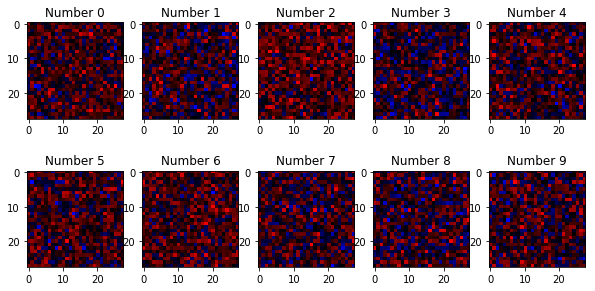

In [76]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST original", one_hot=True)

np.random.seed(100)
tf.set_random_seed(100)
tf.reset_default_graph() 

X_train = mnist.train.images
Yoh_train = mnist.train.labels

X_test = mnist.test.images
Yoh_test = mnist.test.labels

K = 28*28 # 28x28 px images = 784px
C = 10 # 0 1 2 3 4 5 6 7 8 9 = 10 classes
configuration = [K, C]

activation_f = tf.nn.relu
#activation_f = tf.sigmoid
#activation_f = tf.tanh

#configuration, activation_f, param_delta=0.5, param_lambda=1e-3
tfdeep = TFDeep(configuration, activation_f)
tfdeep.train(X_train, Yoh_train, param_niter=10)


from matplotlib.colors import LinearSegmentedColormap

#cmap
cdict = {'blue':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'red':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
        }
cmap = LinearSegmentedColormap('BlueRed1', cdict)

plt.rcParams['figure.figsize'] = [10, 5]
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title('Number {}'.format(i))
    #plt.subplots_adjust(hspace=0.3, wspace=0.05) , interpolation='catrom'
    plt.imshow(tfdeep.get_weights()[i].reshape(28,28), cmap=cmap)#plt.get_cmap('copper'))
plt.show()




- Train the models with configurations `[784,10]`, `[784,100,10]`, `[784,100,100,10]` and `[784,100,100,100,10]` and compare their performance and confusion matrices on train and test sets. If you don't have a functioning GPU, you don't need to run experiments on the last two configurations. Pay attention that deeper models require more iterations and a smaller learning rate. For the most successfull model, plot images which contribute most to the loss function.

In [15]:
def draw_conf_mat(px, py, pi, conf_mat, configuration):
    plt.subplot(px,py,pi)
    plt.imshow(conf_mat, cmap='Reds')
    plt.title('confusion matrix\n{}'.format(str(configuration)))
    plt.xticks(range(10));plt.yticks(range(10));plt.ylabel('true');plt.xlabel('predicted')
    for i in range(10):
        for j in range(10):
            plt.text(i-0.3/px,j,conf_mat[i][j])
    plt.tight_layout()

accuracy model [784,10] = 0.3062
accuracy model [784,100,10] = 0.2882


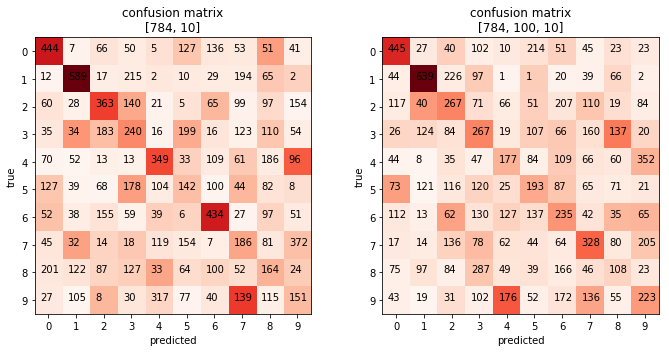

In [16]:
configuration2 = [784, 100, 10]
param_niter=5
#configuration, activation_f, param_delta=0.5, param_lambda=1e-3
tfdeep2 = TFDeep(configuration2, activation_f, param_delta=0.1)
tfdeep2.train(X_train, Yoh_train, param_niter=param_niter, verbose=False)

# evaluate accuracy on test set
X = mnist.test.images
Y_ = mnist.test.labels.argmax(1)

probs = tfdeep.eval(X)
probs2 = tfdeep2.eval(X)
Y = probs.argmax(axis=1)
Y2 = probs2.argmax(axis=1)

print('accuracy model [784,10] = {}'.format(sklearn.metrics.accuracy_score(Y, Y_)))
print('accuracy model [784,100,10] = {}'.format(sklearn.metrics.accuracy_score(Y2, Y_)))

conf_mat = sklearn.metrics.confusion_matrix(Y, Y_)
conf_mat2 = sklearn.metrics.confusion_matrix(Y2, Y_)

draw_conf_mat(1,2,1, conf_mat, [784, 10])
draw_conf_mat(1,2,2, conf_mat2, [784, 100, 10])
plt.show()



- Study the effect of regularization to the performance of deep models on the train and the test subsets.

In [23]:
plt.rcParams['figure.figsize'] = [15, 8]

np.random.seed(100)
tf.set_random_seed(100)
tf.reset_default_graph() 

K = 28*28 # 28x28 px images = 784px
C = 10 # 0 1 2 3 4 5 6 7 8 9 = 10 classes
configuration = [K, C] # [784, 10]

activation_f = tf.nn.relu
#activation_f = tf.sigmoid
#activation_f = tf.tanh
#configuration, activation_f, param_delta=0.5, param_lambda=1e-3

lambdas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]

param_niter = 5
param_delta = 0.1

tfdeeps = []
for param_lambda in enumerate(lambdas):
    tfdeep = TFDeep(configuration, activation_f, param_delta=param_delta, param_lambda=param_lambda)
    tfdeeps.append(tfdeep)

    
# evaluate accuracy on test set
X = mnist.test.images
Y_ = mnist.test.labels.argmax(1)

probs = []
Y = []

for i, model in enumerate(tfdeeps):
    print('model with lambda {}'.format(lambdas[i]))
    model.train(X_train, Yoh_train, param_niter=param_niter, verbose=True)
    probs = model.eval(X)
    Y.append(probs.argmax(axis=1))
    

model with lambda 0.1
0 loss: 427.8378391390115
1 loss: 416.1511959756287
2 loss: 405.3870887147593
3 loss: 395.3925981231466
4 loss: 386.03020951804433
4 loss: 386.03020951804433
model with lambda 0.01
0 loss: 4053.0541242044415
1 loss: 3272.7767523375387
2 loss: 2642.9217674702895
3 loss: 2134.5330041533875
4 loss: 1724.1716715569632
4 loss: 1724.1716715569632
model with lambda 0.001
0 loss: 8000.954496182289
1 loss: 5116.722938178261
2 loss: 3272.182104212537
3 loss: 2092.822103993755
4 loss: 1338.8808099064033
4 loss: 1338.8808099064033
model with lambda 0.0001
0 loss: 11981.123276851376
1 loss: 5868.290377869604
2 loss: 2874.225538143417
3 loss: 1408.3202338681986
4 loss: 690.8903977701399
4 loss: 690.8903977701399
model with lambda 1e-05
0 loss: 15964.518898389591
1 loss: 5745.260899691437
2 loss: 2067.849596677687
3 loss: 745.480321039226
4 loss: 270.3425945432035
4 loss: 270.3425945432035
model with lambda 1e-06
0 loss: 19948.23720401472
1 loss: 4985.512774125761
2 loss: 1246.8

accuracy for model [784, 10] param_lambdas 0.1 = 0.1242
accuracy for model [784, 10] param_lambdas 0.01 = 0.1451
accuracy for model [784, 10] param_lambdas 0.001 = 0.1768


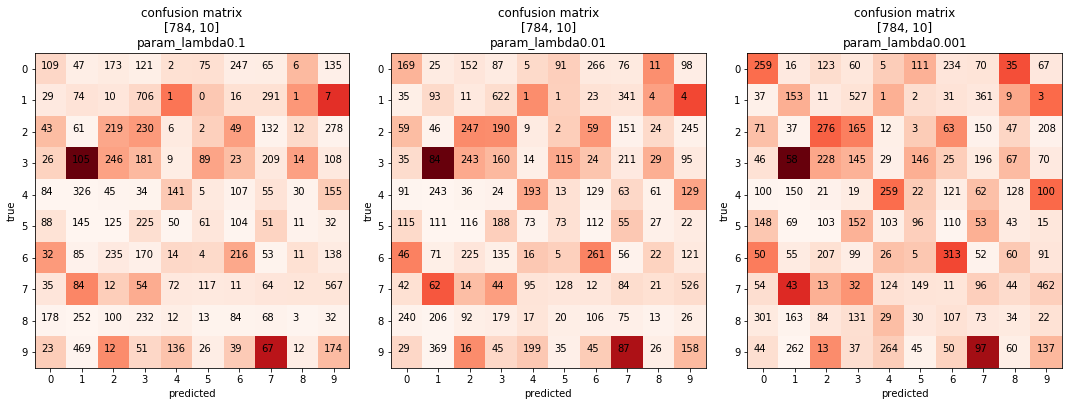

model [784, 10] param_lambdas 0.0001 accuracy = 0.2329
model [784, 10] param_lambdas 1e-05 accuracy = 0.366
model [784, 10] param_lambdas 1e-06 accuracy = 0.5638


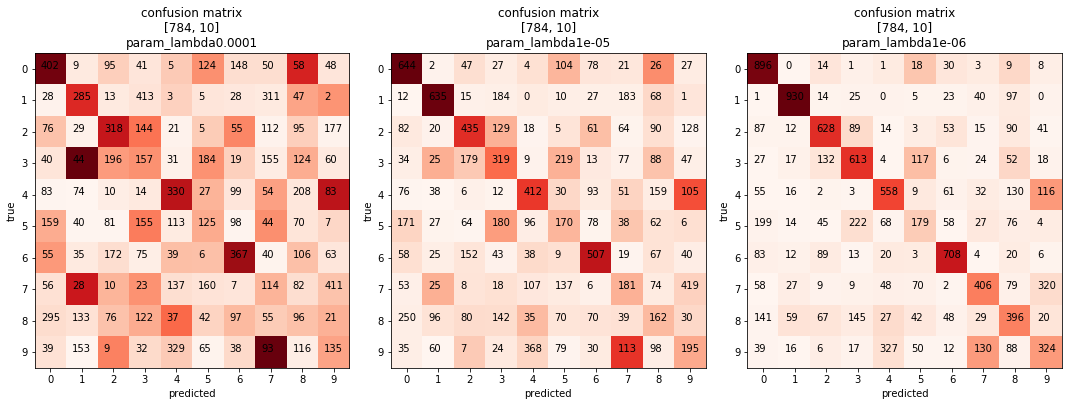

model [784, 10] param_lambdas 1e-07 accuracy = 0.7164
model [784, 10] param_lambdas 1e-08 accuracy = 0.7574
model [784, 10] param_lambdas 1e-09 accuracy = 0.7074


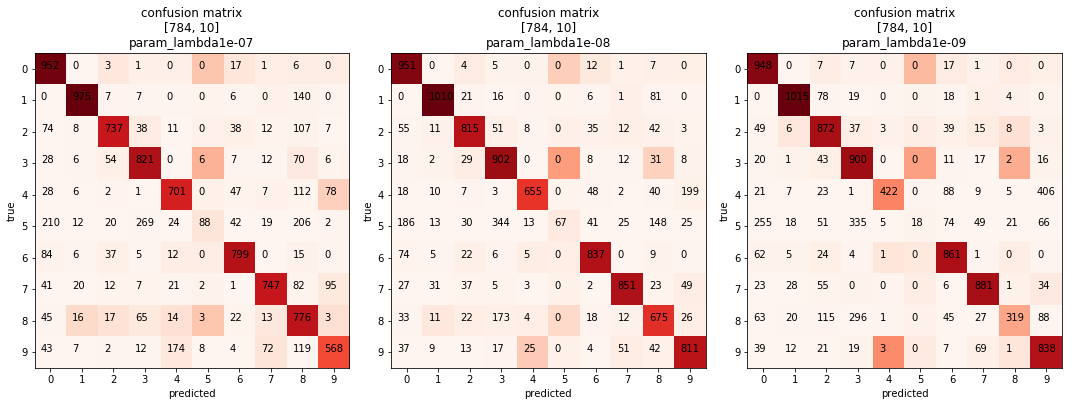

In [24]:
for i, y in enumerate(Y[:3]):
    print('accuracy for model {} param_lambdas {} = {}'.format(str(configuration), lambdas[i], sklearn.metrics.accuracy_score(y, Y_)))
    conf_mat = sklearn.metrics.confusion_matrix(y, Y_)
    draw_conf_mat(1,3,i+1, conf_mat, '[784, 10]\nparam_lambda{}'.format(str(lambdas[i])))
plt.show()

for i, y in enumerate(Y[3:6]):
    print('model {} param_lambdas {} accuracy = {}'.format(str(configuration), lambdas[i+3], sklearn.metrics.accuracy_score(y, Y_)))
    conf_mat = sklearn.metrics.confusion_matrix(y, Y_)
    draw_conf_mat(1,3,i+1, conf_mat, '[784, 10]\nparam_lambda{}'.format(str(lambdas[i+3])))
plt.show()

for i, y in enumerate(Y[6:]):
    print('model {} param_lambdas {} accuracy = {}'.format(str(configuration), lambdas[i+6], sklearn.metrics.accuracy_score(y, Y_)))
    conf_mat = sklearn.metrics.confusion_matrix(y, Y_)
    draw_conf_mat(1,3,i+1, conf_mat, '[784, 10]\nparam_lambda{}'.format(str(lambdas[i+6])))
plt.show()

In [ ]:
'''

import sklearn.model_selection
rand_idx = np.random.choice(mnist.train.images.shape[0],10000)
X = mnist.train.images[rand_idx]/255.0
y = mnist.train.labels[rand_idx]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.3)
print('shuffle')
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
Yoh_train = y_train
Yoh_test = y_test
'''


# predict probabilities of the data points
probs = tfdeep.eval([X_test[1]])
print(probs)
print(np.argmax(probs))
print(Yoh_test[1])

plt.imshow(Xtest[1].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title("Digit: {}".format(Yoh_test[1]))
plt.show()





# perform the training with given hyper-parameters:

#print(tfdeep.get_weights()[0][0])
plt.rcParams['figure.figsize'] = [10, 5]
from matplotlib.colors import LinearSegmentedColormap

#cmap
cdict = {'blue':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'red':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
        }
cmap = LinearSegmentedColormap('BlueRed1', cdict)

'''
#tfdeep.train(X_train, Yoh_train, 10)
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title('Number {}'.format(i))
    #plt.subplots_adjust(hspace=0.3, wspace=0.05) , interpolation='catrom'
    plt.imshow(tfdeep.get_weights()[0][i].reshape(28,28), cmap=cmap)#plt.get_cmap('copper'))
plt.show()
'''

# evaluate accuracy on test set
X = mnist.test.images
Y_ = mnist.test.labels.argmax(1)

probs = tfdeep.eval(X)
Y = probs.argmax(axis=1)
print(Y.shape)

import sklearn.metrics
print(sklearn.metrics.accuracy_score(Y, Y_))

conf_mat = sklearn.metrics.confusion_matrix(Y, Y_)
plt.imshow(conf_mat, cmap='Reds')
plt.title('confusion matrix')
plt.xticks(range(10))
plt.yticks(range(10))
plt.ylabel('true')
plt.xlabel('predicted')
for i in range(10):
    for j in range(10):
        plt.text(i-0.3,j,conf_mat[i][j])

plt.tight_layout()
plt.show()

    


- Randomly separate 1/5 of the training data into the validation set. Evaluate validation performance after each epoch and return the model with the best validation performance (early stopping). Quantify the effect of this procedure to the final loss and to the generalization.
- Implement stohastic gradient descent with training on mini-batches. At the beginning of each epoch, shuffle the data and partition it into `sz_batch` mini-batches. Then perform one training step for each mini-batch. Store the code into the `train_mb` method of the class `TFDeep`. Estimate the effect of the convergence quality and achieved performance for the most successful configuration of the previous assignment.
- Change the optimizer to `tf.train.AdamOptimizer` with fixed learning rate of `1e-4`. Estimate the effect of this change to the quality of convergene and achieved performance.
- Try ADAM with a variable learning rate. Make use of the function [tf.train.exponential_decay](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay). Leave the initial learning rate as before, and change the other hyperparameters to `decay_rate=1-1e-4` i `decay_stepsi=1`.
- Train a linear and a kernel SVM classifier using the module `sklearn.svm`. Use the one vs one SVM variant to allow the classification of multiclass data. The experiment might require some patience since the training and evaluation may takes up to more than half an hour. Compare the achieved performance with the performance of deep models. 

When you are satisfied with the execution results, save the code in the file `mnist_shootout.py`.

# 8. Batch normalization (extra credit)

Study the batch normalization [technique](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization) for fully connected models. Expand the deep classifier by fitting a batchnorm layer after the affine transformations in each hidden layer. Be careful to allow the change of batch-normalization parameters [only](https://www.alexirpan.com/2017/04/26/perils-batch-norm.html) during [training](http://r2rt.com/implementing-batch-normalization-in-tensorflow.html). Compare the performance to what you have obtained with the basic deep model. 